In [160]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse des accidents de la route en France  
## Introduction
Les accidents de la route constituent un enjeu majeur de santé publique en France, avec plusieurs milliers de morts et de blessés graves chaque année. Leur compréhension repose sur l’analyse conjointe de facteurs temporels, environnementaux, infrastructurels et humains.

Ce projet s’appuie sur les données officielles des accidents corporels de la circulation en France, mises à disposition par les autorités publiques. Ces données décrivent, pour chaque accident, ses caractéristiques temporelles, géographiques, environnementales ainsi que certaines informations sur les usagers et les véhicules impliqués.

L’objectif de ce travail est de proposer une analyse statistique exploratoire des accidents de la route, en mettant l’accent sur les facteurs associés à la **gravité des accidents**, tout en tenant compte des limites inhérentes aux données disponibles.


In [161]:
%pip install -r requirements.txt

# modules 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator



# Fonctions
from modules import module_BAAC
from modules import module_region
from modules import graph_baac

Note: you may need to restart the kernel to use updated packages.


### Présentation des données

L’analyse repose principalement sur les jeux de données des accidents de la route survenus en France de 2005 à 2024, ces données sont issues d'API publiques (data.gouv.fr, INSEE et transport.data.gouv.fr). Chaque ligne correspond à un accident et décrit notamment :

- la date et l’heure de l’accident, 
- la localisation géographique (coordonnées, département, commune), 
- les conditions environnementales (luminosité, conditions atmosphériques, état de la chaussée),
- le sexe du conducteur, 
- le nombre de véhicules et d’usagers impliqués, 
- la gravité de l’accident

Le jeux de données antérieurs à 2024 seront mobilisés ponctuellement pour étudier les évolutions temporelles à long terme. Chaque jeu de donnée est intitulé 'BAAC_table_année' et le jeu de donnée regroupant tous les accidents depuis 2005 est intitulé 'BAAC_table'. 


### Construction du dataframe principal

In [162]:
# API Bases de données annuelles des accidents corporels de la circulation routière – 2005 à 2024
BAAC_url = "https://www.data.gouv.fr/api/1/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/"

# API Bases de données sur le parc automobile français
parc_auto_url = "https://www.data.gouv.fr/api/1/datasets/parc-automobile/"

# API INSEE (statistiques socio-économiques)
insee_url = "https://api.insee.fr/series/BDM/V1/data"

# API transport.data.gouv.fr (mobilité et trafic)
transport_url = "https://transport.data.gouv.fr/api/datasets"

In [163]:
BAAC_resources = module_BAAC.get_resources(BAAC_url)
pd.set_option("display.max_rows", None)
pd.options.display.max_colwidth = 300
BAAC_resources[["description", "url"]].head()

,description,url
0,Liste des véhicules immatriculés (hors vélos et engins de déplacement personnel) impliqués dans les accidents corporels issus des BAAC (Bulletin d’Analyse des Accidents Corporels de la circulation) relevés par les forces de l’ordre en 2024.\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100210/2024.csv
1,Liste des véhicules immatriculés (hors vélos et engins de déplacement personnel) impliqués dans les accidents corporels issus des BAAC (Bulletin d’Analyse des Accidents Corporels de la circulation) relevés par les forces de l’ordre en 2023.\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-142813/2023.csv
2,Table des caractéristiques des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv
3,Table des lieux des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv
4,Table des véhicules impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100240/vehicules-2024.csv


In [164]:
selected_BAAC_table = module_BAAC.select_baac_tables(BAAC_resources)
selected_BAAC_table.head(2)

,description,url,table,year
0,Table des caractéristiques des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv,caracteristiques,2024
1,Table des lieux des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv,lieux,2024
2,Table des véhicules impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100240/vehicules-2024.csv,vehicules,2024
3,Table des usagers impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115506/usagers-2024.csv,usagers,2024
4,Table des usagers impliqués dans les accidents corporels de la circulation en 2023 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241023-153328/usagers-2023.csv,usagers,2023
5,Table des véhicules impliqués dans les accidents corporels de la circulation en 2023 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241023-153253/vehicules-2023.csv,vehicules,2023
6,Table des lieux des accidents corporels de la circulation en 2023 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241023-153219/lieux-2023.csv,lieux,2023
7,Table des caractéristiques des accidents corporels de la circulation en 2023 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241028-103125/caract-2023.csv,caracteristiques,2023
8,Table des usagers impliqués dans les accidents corporels de la circulation en 2022 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/20231005-094229/usagers-2022.csv,usagers,2022
9,Table des véhicules impliqués dans les accidents corporels de la circulation en 2022 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/20231005-094147/vehicules-2022.csv,vehicules,2022


In [165]:
BAAC_table = module_BAAC.build_baac_dataframe(selected_BAAC_table)
BAAC_table.head()

,Num_Acc,id_vehicule_x,num_veh_x,place,catu,grav,sexe,an_nais,trajet,secu1,...,com,agg,int,atm,col,adr,lat,long,year,id_usager
0,202000000001,154 742 274,B01,1,1,1,1,1983.0,5,1,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
1,202000000001,154 742 274,B01,1,1,1,1,1983.0,5,1,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
2,202000000001,154 742 275,A01,1,1,3,1,1982.0,5,2,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
3,202000000001,154 742 275,A01,1,1,3,1,1982.0,5,2,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
4,202000000002,154 742 273,A01,1,1,1,1,1997.0,1,8,...,91657,2,9,7,6,MOUSSEAUX(CHEMIN),48.69000,2.41000,2020,NaN


### Choix des variables conservées

La table principale BAAC_table comporte 61 variables, qui ne sont pas toutes pertinentes dans le cadre de cette étude. Nous avons décidé de conserver les variables suivantes : 'grav' (gravité de l'accident), 'year', 'mois', 'jour', 'hrmn' (→ heure), 'lat', 'long', 'dep', 'agg' (agglomération ou non), 'vma' (vitesse limite), 'nbv', 'catr', 'circ', 'lum', 'atm', 'surf' (paramètres physiques), 'sexe', 'an_nais' (année de naissance). Sur certaines tables, 'hrmn' est un string de la forme 'HH:MM' (avant 2019), sur d'autres 'hrmn' est de la fome HHMM, nous avons donc remplacé 'hmrn' par une variable 'hour' en conservant seulement l'heure de l'accident HH de type int. 


In [166]:
df = BAAC_table.copy()
df['hour'] = df['hrmn'].apply(graph_baac.hrmn_to_hour)

variables_conservees = ["Num_Acc", "grav", "year", "mois", "jour", "hour", "lat", "long", "dep", "agg",
 "vma", "nbv", "catr", "circ", "lum", "atm", "surf", "sexe", "an_nais"]

BAAC_table_trie = df[variables_conservees]

BAAC_table_trie.describe()


,Num_Acc,grav,year,mois,jour,hour,lat,long,agg,vma,catr,circ,lum,atm,surf,sexe,an_nais
count,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.281321e+06
mean,2.022213e+11,2.455298e+00,2.022212e+03,6.719709e+00,1.559720e+01,1.369625e+01,4.431460e+01,2.072458e+00,1.599494e+00,6.032207e+01,3.213699e+00,1.819424e+00,1.891026e+00,1.609295e+00,1.251029e+00,1.275221e+00,1.983727e+03
std,1.390214e+08,1.397289e+00,1.390207e+00,3.349796e+00,8.754248e+00,5.370833e+00,1.222441e+01,1.907064e+01,4.900011e-01,2.755965e+01,1.279880e+00,9.233002e-01,1.471151e+00,1.665236e+00,7.623527e-01,5.495914e-01,1.853866e+01
min,2.020000e+11,-1.000000e+00,2.020000e+03,1.000000e+00,1.000000e+00,0.000000e+00,-2.386900e+01,-1.781581e+02,1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.900000e+03
25%,2.021000e+11,1.000000e+00,2.021000e+03,4.000000e+00,8.000000e+00,1.000000e+01,4.471771e+01,1.358507e+00,1.000000e+00,5.000000e+01,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.971000e+03
50%,2.022000e+11,3.000000e+00,2.022000e+03,7.000000e+00,1.500000e+01,1.500000e+01,4.785757e+01,2.398398e+00,2.000000e+00,5.000000e+01,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.987000e+03
75%,2.023001e+11,4.000000e+00,2.023000e+03,1.000000e+01,2.300000e+01,1.800000e+01,4.886265e+01,4.803793e+00,2.000000e+00,8.000000e+01,4.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.999000e+03
max,2.024001e+11,4.000000e+00,2.024000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.107874e+01,1.681065e+02,2.000000e+00,9.010000e+02,9.000000e+00,4.000000e+00,5.000000e+00,9.000000e+00,9.000000e+00,2.000000e+00,2.024000e+03


On crée ensuite les tables associées à chaque année à partir de la table principale : 

### Valeurs manquantes
 
La table principale étant issue de la concaténation de vingt sous-tables, il est nécessaire de vérifier la proportion de mesures disponibles pour chaque variable et chaque année, afin d’éviter d’effectuer des analyses sur des valeurs manquantes (NaN).

Un tableau a été élaboré pour représenter, année par année, la proportion de valeurs effectivement renseignées pour chaque variable. Il permet par exemple de constater que que la variable 'vma' n’a été introduite qu’à partir de 2019. 

In [167]:
for i in range(2005, 2025):
    globals()[f'BAAC_table_{i}'] = BAAC_table_trie.loc[BAAC_table_trie['year'] == i].reset_index(drop=True)


In [168]:
l = ["grav", "year", "mois", "jour", "hour", "lat", "long", "dep", "agg",
 "vma", "nbv", "catr", "circ", "lum", "atm", "surf", "sexe", "an_nais"]     


years = range(2020, 2025)
df_proportion = pd.DataFrame(index=years, columns=l)

for i in years:
    table = globals()[f'df_{i}']
    for var in l:
        df_proportion.loc[i, var] = 1 - table[var].isna().sum() / len(table)

df_proportion = df_proportion.astype(float)

# df_proportion = df_proportion.loc[:, (df_proportion != 1).any(axis=0)]

df_proportion.head()

,Num_Acc,grav,year,mois,jour,hour,lat,long,dep,agg,vma,nbv,catr,circ,lum,atm,surf,sexe,an_nais
2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.976965
2022,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.978504
2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979453
2024,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979920


Le choix des variables conservées est donc plutôt satisfaisant puisque les valeurs du tableau sont pour la plupart proches de 1. Il est enfin nécessaire de convertir toutes les variables conservées en int, ou en float, comme par exemple les coordonnées qui sont de type str comme on peut le voir ci-dessous.

In [169]:
for i in range(2020,2025) :
    table = globals()[f'df_{i}'][['lat', 'long']].dropna()
    print(i,':', table['lat'].iloc[0], table['long'].iloc[0])
    

2020 : 48.70535 2.43841
2021 : 44.038958 4.348022
2022 : 44.55942 4.72572
2023 : 48.866386 2.323471
2024 : 47.56277 6.75832


On utilise pour cela les fonctions normalize_coordinates et to_int

In [170]:
BAAC_table_norm = graph_baac.normalize_coordinates(BAAC_table_trie)
BAAC_table_norm = graph_baac.to_int(BAAC_table_norm)
BAAC_table_norm.describe()

,Num_Acc,grav,year,mois,jour,hour,lat,long,agg,vma,catr,circ,lum,atm,surf,sexe,an_nais
count,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304745e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.304746e+06,1.281321e+06
mean,2.022213e+11,2.455298e+00,2.022212e+03,6.719709e+00,1.559720e+01,1.369625e+01,4.431460e+01,2.072459e+00,1.599494e+00,6.032207e+01,3.213699e+00,1.819424e+00,1.891026e+00,1.609295e+00,1.251029e+00,1.275221e+00,1.983727e+03
std,1.390214e+08,1.397289e+00,1.390207e+00,3.349796e+00,8.754248e+00,5.370833e+00,1.222441e+01,1.907064e+01,4.900011e-01,2.755965e+01,1.279880e+00,9.233002e-01,1.471151e+00,1.665236e+00,7.623527e-01,5.495914e-01,1.853866e+01
min,2.020000e+11,-1.000000e+00,2.020000e+03,1.000000e+00,1.000000e+00,0.000000e+00,-2.386900e+01,-1.781581e+02,1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.900000e+03
25%,2.021000e+11,1.000000e+00,2.021000e+03,4.000000e+00,8.000000e+00,1.000000e+01,4.471771e+01,1.358507e+00,1.000000e+00,5.000000e+01,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.971000e+03
50%,2.022000e+11,3.000000e+00,2.022000e+03,7.000000e+00,1.500000e+01,1.500000e+01,4.785757e+01,2.398398e+00,2.000000e+00,5.000000e+01,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.987000e+03
75%,2.023001e+11,4.000000e+00,2.023000e+03,1.000000e+01,2.300000e+01,1.800000e+01,4.886265e+01,4.803793e+00,2.000000e+00,8.000000e+01,4.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.999000e+03
max,2.024001e+11,4.000000e+00,2.024000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.107874e+01,1.681065e+02,2.000000e+00,9.010000e+02,9.000000e+00,4.000000e+00,5.000000e+00,9.000000e+00,9.000000e+00,2.000000e+00,2.024000e+03


Après avoir nettoyé BAAC_table, on fait de même avec les tables associées à chaque année : 

## Problématique

Si la fréquence et la localisation des accidents de la route sont relativement bien documentées, la compréhension des **facteurs associés à la gravité des accidents** reste un enjeu central pour l’analyse et la prévention du risque routier.

La problématique principale de ce projet est donc la suivante :

> *Dans quelles conditions temporelles, environnementales et infrastructurelles les accidents de la route sont-ils les plus graves ?*

Cette question sera abordée à travers une analyse descriptive, exploratoire et multivariée des données, sans prétendre établir des relations causales strictes.


### Enjeux et choix méthodologiques

Plusieurs enjeux méthodologiques structurent ce travail :

Premièrement, les données sont observationnelles et ne permettent pas d’identifier des relations causales directes. De plus les variables territoriales agrégées (régions, départements) sont peu nombreuses au regard du nombre d’accidents observés, ce qui limite leur exploitation dans des modèles explicatifs.

En conséquence, l’analyse privilégie une approche descriptive pour dresser un état des lieux des accidents, une analyse exploratoire multivariée (ACP) pour comprendre la structure des relations entre variables ainsi que des modèles de régression visant à identifier les variables **associées** à la gravité des accidents.


## Organisation du notebook

Le notebook est structuré comme suit :

I. Analyse descriptive des accidents de la route  
II. Analyse exploratoire multivariée  
III. Analyse des facteurs associés à la gravité des accidents  
IV. Discussion des résultats et limites  
V. Conclusion

Chaque partie combine des visualisations graphiques et des analyses statistiques adaptées aux objectifs poursuivis.


## I. Analyse descriptive des accidents de la route


A remplir

On commence par une analyse pûrement descriptive. On va plot quelques graphes significatifs, dégager des dynamiques temporelles en soulignant qu'elles sont faibles, ce qui justifiera le choix de ne sélectionner qu'une seule partie dans le II. 

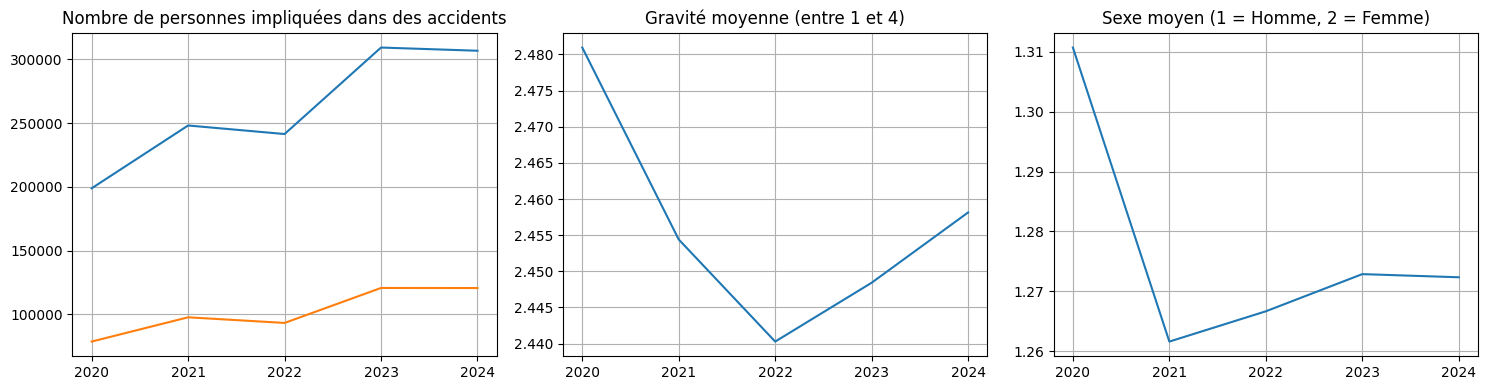

In [171]:
liste_df = [globals()[f'BAAC_table_{i}'] for i in range(2020, 2025)]
annees = range(2020, 2025)
occurences, occurences_graves, grav_moy, sexe_moy = graph_baac.dynamiques_temporelles(liste_df)

fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 
for ax in axs : 
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


axs[0].plot(annees, occurences, label = 'accidents')
axs[0].grid(True)
axs[0].plot(annees, occurences_graves, label = 'accidents graves')
axs[0].set_title("Nombre de personnes impliquées dans des accidents")

axs[1].plot(annees, grav_moy)
axs[1].grid(True)
axs[1].set_title("Gravité moyenne (entre 1 et 4)")

axs[2].plot(annees, sexe_moy)
axs[2].grid(True)
axs[2].set_title("Sexe moyen (1 = Homme, 2 = Femme)")

plt.tight_layout()
plt.show()


A remplir

plt.show()

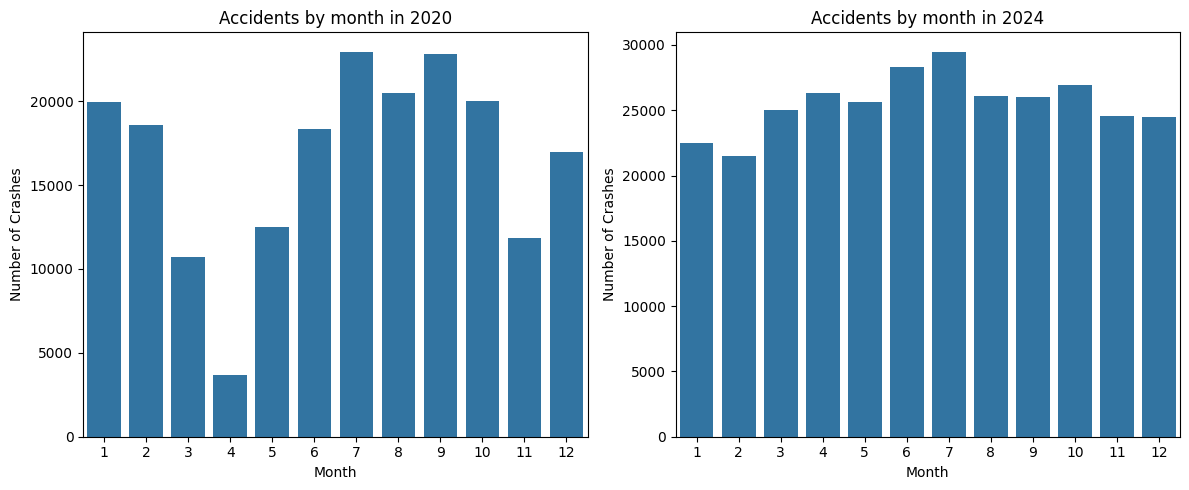

In [172]:
dfs = [df_2020, df_2024]
graph_baac.plot_multiple(dfs, graph_baac.plot_accidents_heatmap_cote_a_cote, ['Année 2020', 'Année 2024'])

A remplir

fig, axs = plt.subplots(1, len(dfs), figsize=(12, 5))
if len(dfs) == 1:
    axs = [axs]

for i, df in enumerate(dfs):
    graph_baac.plot_crashes_per_month(df, ax=axs[i], title=f'Accidents by month in {2020 + 4*i}')

plt.tight_layout()
plt.show()

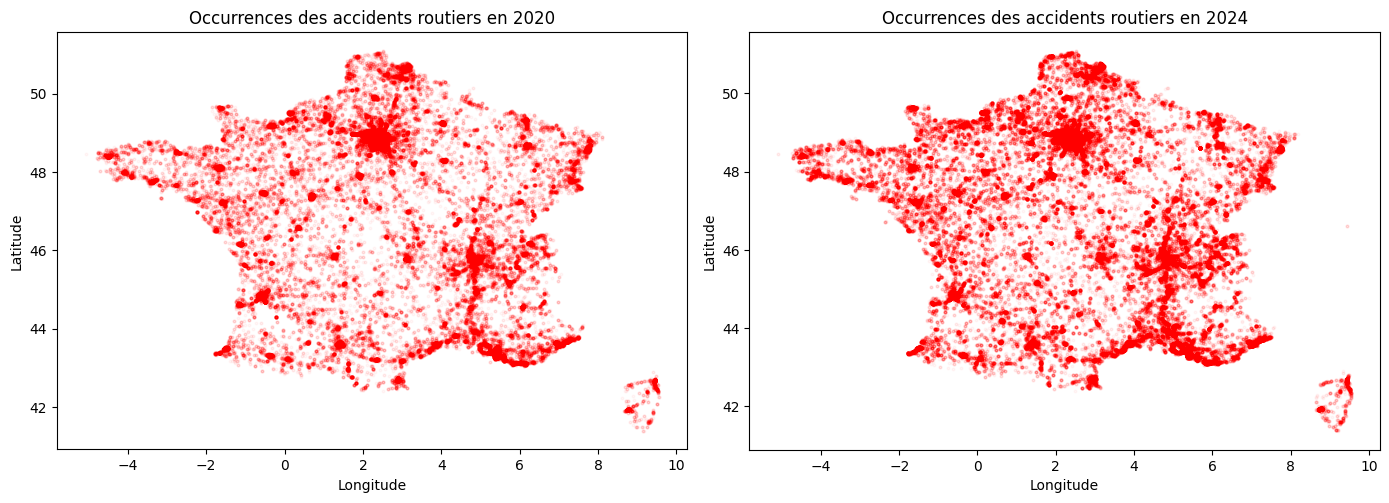

In [173]:
dfs = [BAAC_table_2020, BAAC_table_2024]
years = [2020, 2024]

graph_baac.plot_multiple(dfs, graph_baac.plot_crashes_heatmap_cote_a_cote, titles)

A remplir

Enfin, cette heatmap permet de finir de constater que le nombre a augmenté au cours des 5 dernières années, mais la répartition est globalement la même. C'est pourquoi dans la suite de l'étde on se concentrera sur le dataset lié à l'année 2024.

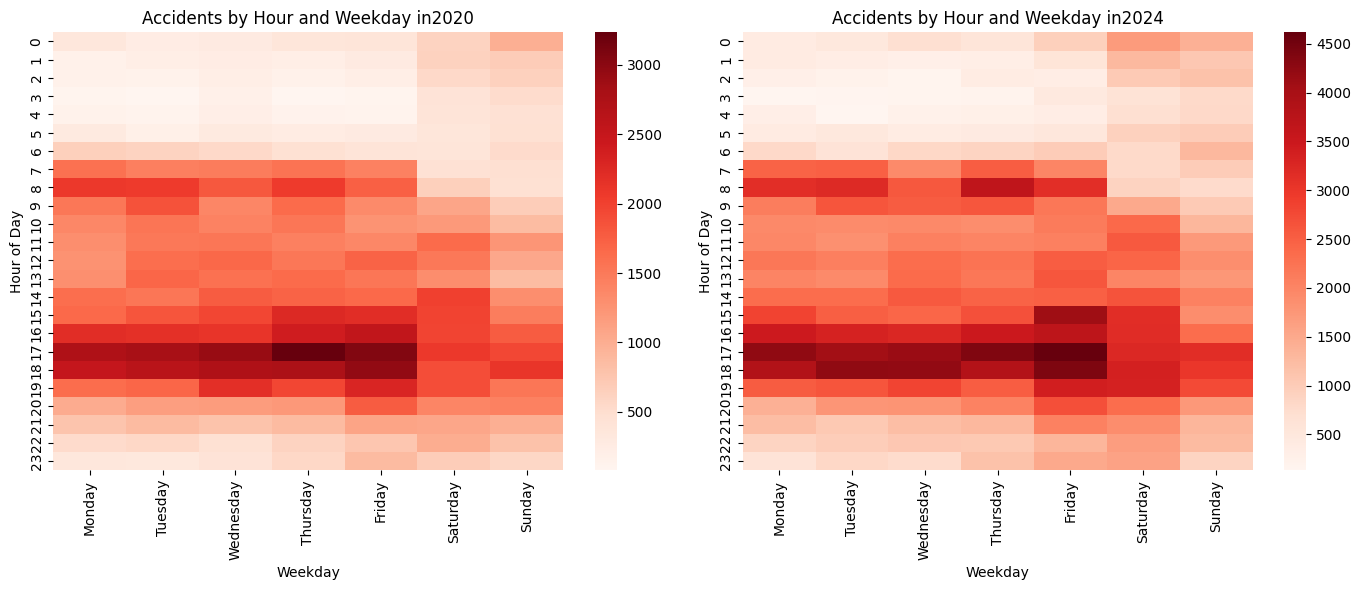

In [174]:
BAAC_table_norm['date'] = pd.to_datetime(BAAC_table_norm['year'].astype(str) + '-' + 
                            BAAC_table_norm['mois'].astype(str) + '-' + 
                            BAAC_table_norm['jour'].astype(str))

BAAC_table_norm['weekday'] = BAAC_table_norm['date'].dt.day_name()
    
for i in range(2005, 2025):
    globals()[f'BAAC_table_{i}'] = BAAC_table_norm.loc[BAAC_table_norm['year'] == i].reset_index(drop=True)

dfs = [BAAC_table_2020, BAAC_table_2024]
fig, axs = plt.subplots(1, len(dfs), figsize=(14, 6))

if len(dfs) == 1:
    axs = [axs]

for i, df in enumerate(dfs):
    graph_baac.plot_accidents_heatmap_cote_a_cote(df, ax=axs[i], title=f'Accidents by Hour and Weekday in{2020 + 4*i}')
    
plt.tight_layout()
plt.show()


## II. Analyse exploratoire multivariée  

A remplir

L'objectif principal de ce projet est de comprendre les facteurs liés au risque d'accident sur la route. On se propose dans un premier temps d'observer les données de manière exploratoire à l'aide d'analyses en composantes principales. Dans un premier temps en conservant toutes les variables, puis en extrayant les variables expliquant le mieux la variance, et en les combinant avec les variables que l'on considère pertinentes pour observer les corrélations entre elles. Enfin on effectuera une régression multivariée afin d'exliquer la gravité de l'accident. 

### ACP prenant en compte toutes les variables